# Exploratory Data Analysis — Spaced Repetition Dataset

This notebook walks through exploratory data analysis of the Duolingo-style spaced repetition dataset. Goals:
- load and inspect the data
- clean and create simple features (time units)
- visualize distributions and an empirical forgetting curve
- fit a simple half-life regression baseline: P(recall) = 2^{-t/h}

Dataset file used: `data/SpacedRepetitionData.csv`

## Information about the dataset: 

https://github.com/duolingo/halflife-regression

The Duolingo Spaced Repetition Dataset was released to support research on computational modeling of human memory and personalized review scheduling. It was used to develop Duolingo’s Half-Life Regression (HLR) model, a parametric model designed to estimate the probability that a learner will correctly recall a word as a function of time.

The dataset contains approximately 13 million user–lexeme interaction records collected from learners studying multiple target languages with diverse native language backgrounds.

The fundamental observation unit is a (user, word) practice event, meaning that each row represents a single instance where a learner was tested on a specific lexical item.

Overview dataset
Each row in the dataset represents a single recall event for one
user–lexeme pair at a specific time. The dataset is designed to model
probability of recall as a function of time and prior exposure history.

Variable Descriptions

1.  p_recall Type: Float in [0,1] Meaning: Empirical recall probability
    at that practice event. Typically computed as: p_recall =
    session_correct / session_seen This allows probabilistic regression
    instead of binary classification.

2.  timestamp Type: Unix time (seconds) Meaning: Absolute time of the
    practice interaction.

3.  delta Type: Integer (seconds) Meaning: Time elapsed since the
    previous exposure to the same lexeme by the same user. This is the
    key variable for modeling forgetting curves.

4.  user_id Anonymized learner identifier. Used for personalization and
    learner-specific modeling.

5.  learning_language Language being learned (L2).

6.  ui_language Interface language (usually learner’s native language).
    Enables cross-linguistic modeling.

7.  lexeme_id Unique identifier for the lexical item.

8.  lexeme_string Morphologically annotated word representation.
    Example: lernt/lernen

Breakdown: lernt -> surface form lernen -> lemma -> lexical verb ->
present tense -> third person -> singular

Allows morphological feature extraction and grammatical difficulty
modeling.

9.  history_seen Total number of times the user has seen this lexeme
    before this event.

10. history_correct Number of times previously answered correctly.
    Historical accuracy can be computed as: history_correct /
    history_seen

11. session_seen Number of times seen within the current session.

12. session_correct Number correct within the current session. Used to
    compute p_recall.

Mathematical Model (Half-Life Regression)

Recall probability is modeled as:

    P(recall) = 2^(-t / h)

where: t = delta (time since last practice) h = half-life parameter

Half-life is modeled as:

    $$ h = exp(w^T x) $$ 

where: x = feature vector (history, lexical, language features) w =
learned parameters

This connects the dataset to exponential decay models, survival
analysis, and cognitive memory modeling.

Nevertheless, these data do not limit data scientists in practics. A lot of interesting things can be done with it! Think out of the box, and impress us at the datathon pitches!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
%matplotlib inline

In [3]:
path = 'data/SpacedRepetitionData.csv'
df = pd.read_csv(path)
print('Rows, cols:', df.shape)
df.head()

Rows, cols: (12854226, 12)


,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1


In [4]:
# Quick info and basic statistics
df.info()

# Summary stats for numeric columns
df.describe(include='all')

<class 'pandas.DataFrame'>
RangeIndex: 12854226 entries, 0 to 12854225
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   p_recall           float64
 1   timestamp          int64  
 2   delta              int64  
 3   user_id            str    
 4   learning_language  str    
 5   ui_language        str    
 6   lexeme_id          str    
 7   lexeme_string      str    
 8   history_seen       int64  
 9   history_correct    int64  
 10  session_seen       int64  
 11  session_correct    int64  
dtypes: float64(1), int64(6), str(5)
memory usage: 1.1 GB


,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
count,1.285423e+07,1.285423e+07,1.285423e+07,12854226,12854226,12854226,12854226,12854226,1.285423e+07,1.285423e+07,1.285423e+07,1.285423e+07
unique,NaN,NaN,NaN,115222,6,4,19279,18781,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,u:bcH_,en,en,827a8ecb89f9b59ac5c29b620a5d3ed6,a/a<det><ind><sg>,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,19194,5014791,7839435,123099,123099,NaN,NaN,NaN,NaN
mean,8.961056e-01,1.362589e+09,7.295811e+05,NaN,NaN,NaN,NaN,NaN,2.198109e+01,1.935025e+01,1.817686e+00,1.644134e+00
std,2.714048e-01,2.932082e+05,2.246499e+06,NaN,NaN,NaN,NaN,NaN,1.295508e+02,1.119681e+02,1.360180e+00,1.318794e+00
min,0.000000e+00,1.362076e+09,1.000000e+00,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.362343e+09,5.320000e+02,NaN,NaN,NaN,NaN,NaN,3.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
50%,1.000000e+00,1.362591e+09,7.713400e+04,NaN,NaN,NaN,NaN,NaN,6.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00
75%,1.000000e+00,1.362846e+09,4.425070e+05,NaN,NaN,NaN,NaN,NaN,1.500000e+01,1.300000e+01,2.000000e+00,2.000000e+00


In [5]:
# Missing values overview
missing = df.isna().sum().sort_values(ascending=False)
missing[missing>0]

Series([], dtype: int64)

## Basic visualizations
Plot key distributions: `p_recall`, `delta` (time since previous exposure), and `history_seen`.

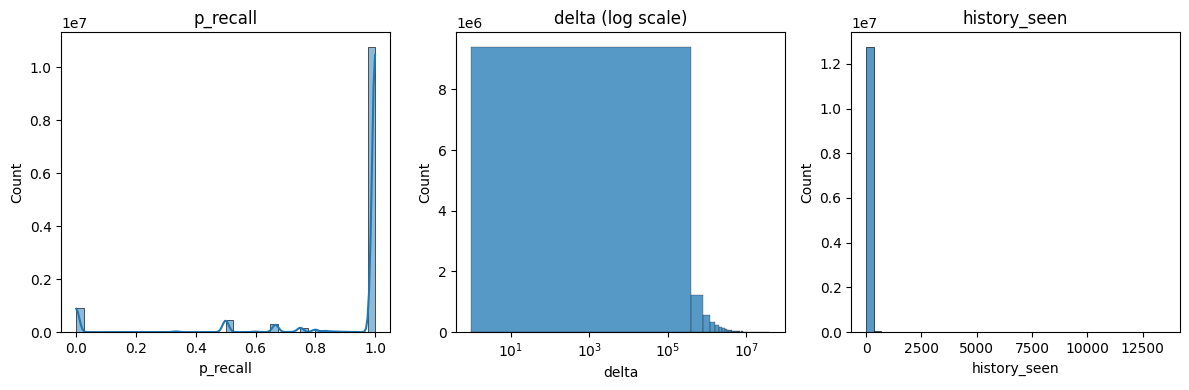

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(df['p_recall'].dropna(), bins=40, kde=True)
plt.title('p_recall')

plt.subplot(1,3,2)
# delta is typically in seconds; distribution is heavy-tailed
sns.histplot(df['delta'].dropna(), bins=100)
plt.xscale('log')
plt.title('delta (log scale)')

plt.subplot(1,3,3)
sns.histplot(df['history_seen'].dropna(), bins=40)
plt.title('history_seen')
plt.tight_layout()

## Empirical forgetting curve
We'll compute mean recall probability grouped by time since last exposure. Because `delta` is in seconds, we'll convert to days for interpretability and use log-bins to capture wide range.

In [ ]:
# Prepare data for forgetting curve
df2 = df[['delta','p_recall']].dropna().copy()
df2['days'] = df2['delta'] / 86400.0
# Remove non-positive or extremely small values
df2 = df2[df2['days']>0]
# Create log-spaced bins for days
bins = np.concatenate((np.linspace(0,1,20)[1:], np.logspace(0,3,30)))
labels = 0.5*(bins[:-1] + bins[1:])
df2['bin'] = pd.cut(df2['days'], bins=bins, labels=labels)
group = df2.groupby('bin')['p_recall'].agg(['mean','count']).dropna()
group = group[group['count']>50]  # keep bins with sufficient samples
plt.figure(figsize=(8,5))
plt.plot(group.index.astype(float), group['mean'], marker='o')
plt.xscale('log')
plt.xlabel('Days since last exposure (log scale)')
plt.ylabel('Empirical mean p_recall')
plt.title('Empirical forgetting curve')
plt.grid(True)
plt.show()

## Fit a simple half-life regression baseline
We fit P(t) = 2^{-t/h} with a single parameter `h` (half-life in days) as a baseline. This is a simple non-linear fit on the empirical points.

In [ ]:
# Use the grouped empirical points from above for fitting
t = group.index.astype(float).values  # days (bin centers)
p = group['mean'].values
# Define model: P(t) = 2^(-t/h)
def p_model(t, h):
    return 2 ** (-t / h)
# Clip p to avoid exact 0 or 1 which break transforms
p_clipped = np.clip(p, 1e-6, 1-1e-6)
# Initial guess for h (days)
p0 = [7.0]
try:
    popt, pcov = curve_fit(p_model, t, p_clipped, p0=p0, maxfev=10000)
    h_est = popt[0]
    print(f'Estimated half-life h = {h_est:.3f} days')
    # Plot fit against empirical points
    tt = np.logspace(np.log10(t.min()*0.9), np.log10(t.max()*1.1), 200)
    plt.figure(figsize=(7,4))
    plt.plot(t, p, 'o', label='empirical')
    plt.plot(tt, p_model(tt, h_est), '-', label=f'fit: h={h_est:.2f} days')
    plt.xscale('log')
    plt.xlabel('Days since last exposure (log)')
    plt.ylabel('p_recall')
    plt.legend()
    plt.title('Half-life regression baseline')
    plt.show()
except Exception as e:
    print('Curve fit failed:', e)

## Summary and next steps
- We loaded and inspected the dataset, visualized distributions and an empirical forgetting curve.
- A simple single-parameter half-life model was fit as a baseline.

Next steps you may want to try:
- Fit conditional half-life models: h = exp(w^T x) using features (history_seen, history_correct, lexeme features).
- Use cross-validation and per-user / per-lexeme mixed-effects models.
- Explore richer models: logistic regression, survival models, or nonparametric smoothing.